# Dataset

## Description du dataset "frenchNER_4entities" :
Ce corpus, proposé par CATIE-AQ sur Hugging Face, est destiné à la tâche de reconnaissance d'entités nommées (NER) en français. Il contient des textes annotés selon quatre catégories d'entités – typiquement, celles-ci peuvent être des entités telles que Personne, Organisation, Lieu et une quatrième catégorie (par exemple, Entité Générique ou autre, selon la documentation précise du dataset). Ce dataset est utile pour entraîner et évaluer des modèles de NER sur des données en français, en offrant un benchmark dédié pour le traitement de la langue et permettant d'explorer les spécificités linguistiques du français en matière d'extraction d'entités.

## Analyse du dataset

Noms des étiquettes : ['O', 'PER', 'ORG', 'LOC', 'MISC']

Longueur moyenne des phrases (en tokens) : 27.558850457937016

Distribution des types d'entités :
PER : 169311
MISC : 260638
ORG : 52609
LOC : 188806

Top 10 des entités les plus fréquentes :
. : 30378
France : 3319
? : 2662
amphibiens : 2294
États-Unis : 2044
Paris : 1912
Female : 1811
Male : 1802
Europe : 1623
États - Unis : 1596

Exemples de formatage pour GLiNER :
[ENT] PER [ENT] ORG [ENT] LOC [ENT] MISC [SEP] On a souvent voulu faire de La Bruyère une sorte de réformateur , de démocrate , un " précurseur de la Révolution française " .
-----
[ENT] PER [ENT] ORG [ENT] LOC [ENT] MISC [SEP] Les améliorations apportées par rapport à Wolfenstein 3D , la précédente réalisation d' id Software , ont été permises par des ajouts de fonctionnalités dans le Doom engine réellement novateur à plus d' un titre :
-----
[ENT] PER [ENT] ORG [ENT] LOC [ENT] MISC [SEP] Cette assemblée de notables , réunie en août , permet à Gaspard de Coligny ,

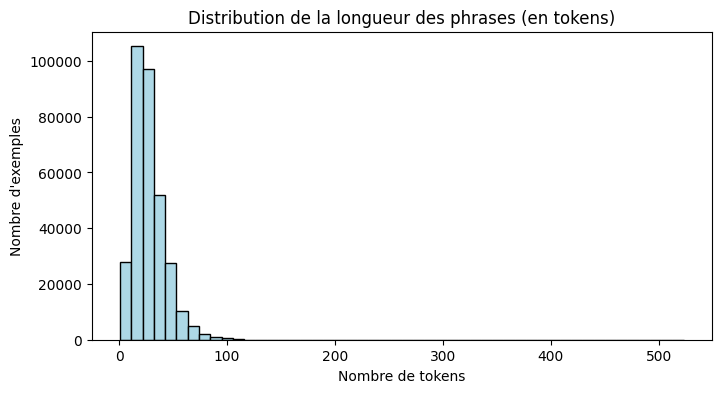

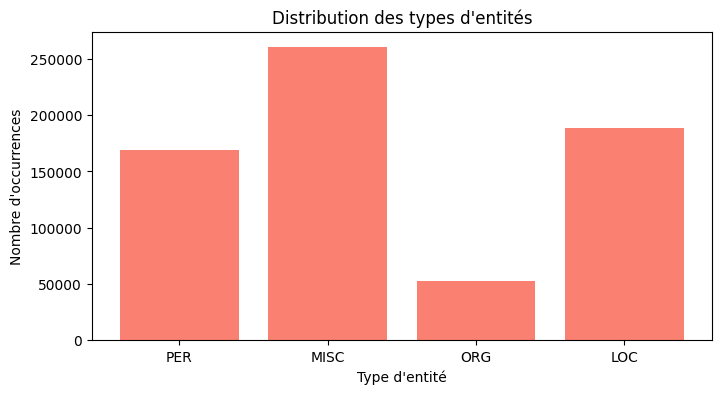

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter

# Charger le dataset "frenchNER_4entities" depuis Hugging Face
dataset = load_dataset("CATIE-AQ/frenchNER_4entities")

# Essayer de récupérer les noms des étiquettes depuis les features,
# sinon, définir manuellement le mapping (0: "O", 1: "PER", 2: "ORG", 3: "LOC", 4: "MISC")
try:
    label_names = dataset['train'].features['ner_tags'].feature.names
except AttributeError:
    label_names = ["O", "PER", "ORG", "LOC", "MISC"]
print("Noms des étiquettes :", label_names)

#####################################
# 1. Extraction et Prétraitement
#####################################

def extract_entities(tokens, ner_tags, label_names):
    """
    Extrait les entités en regroupant les tokens consécutifs ayant le même label (différent de "O").
    Retourne une liste de dictionnaires contenant le texte de l'entité, son label, et ses indices de début et fin.
    """
    entities = []
    current_entity = None
    for i, (token, tag) in enumerate(zip(tokens, ner_tags)):
        label = label_names[tag]
        if label == "O":
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None
        else:
            if current_entity is None:
                current_entity = {"label": label, "tokens": [token], "start": i, "end": i}
            else:
                if current_entity["label"] == label:
                    current_entity["tokens"].append(token)
                    current_entity["end"] = i
                else:
                    entities.append(current_entity)
                    current_entity = {"label": label, "tokens": [token], "start": i, "end": i}
    if current_entity is not None:
        entities.append(current_entity)
    # Conversion de la liste de tokens en chaîne de caractères pour chaque entité
    for entity in entities:
        entity["text"] = " ".join(entity["tokens"])
    return entities

# Initialisation des listes pour stocker les longueurs de phrases et toutes les entités extraites
all_entities = []
sentence_lengths = []

for i in range(len(dataset['train'])):
    example = dataset['train'][i]
    tokens = example['tokens']
    ner_tags = example['ner_tags']
    sentence_lengths.append(len(tokens))
    entities = extract_entities(tokens, ner_tags, label_names)
    all_entities.extend(entities)

#####################################
# 2. Analyse Statistique
#####################################

# Longueur moyenne des phrases
avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
print("\nLongueur moyenne des phrases (en tokens) :", avg_sentence_length)

# Distribution des types d'entités
entity_label_counts = Counter([entity["label"] for entity in all_entities])
print("\nDistribution des types d'entités :")
for label, count in entity_label_counts.items():
    print(f"{label} : {count}")

# Fréquence des différentes entités (texte)
entity_text_counts = Counter([entity["text"] for entity in all_entities if entity["text"].strip() != ""])
print("\nTop 10 des entités les plus fréquentes :")
for entity, count in entity_text_counts.most_common(10):
    print(f"{entity} : {count}")

#####################################
# 3. Mise en forme pour GLiNER
#####################################

# GLiNER attend une entrée sous la forme :
# "[ENT] <type_entité1> [ENT] <type_entité2> ... [SEP] <texte de la phrase>"
# On exclut l'étiquette "O" du prompt.
gliner_entity_types = [etype for etype in label_names if etype != "O"]

def format_for_gliner(tokens, gliner_entity_types):
    """
    Construit une chaîne de caractères combinant le prompt (avec les types d'entités) et le texte de la phrase.
    """
    sentence_text = " ".join(tokens)
    entity_prompt = " ".join([f"[ENT] {etype}" for etype in gliner_entity_types])
    unified_input = f"{entity_prompt} [SEP] {sentence_text}"
    return unified_input

# Exemple de formatage pour les 5 premiers exemples du split 'train'
formatted_examples = [format_for_gliner(dataset['train'][i]['tokens'], gliner_entity_types) for i in range(5)]
print("\nExemples de formatage pour GLiNER :")
for ex in formatted_examples:
    print(ex)
    print("-----")

#####################################
# 4. Visualisations
#####################################

# Histogramme de la longueur des phrases
plt.figure(figsize=(8, 4))
plt.hist(sentence_lengths, bins=50, color='lightblue', edgecolor='black')
plt.title("Distribution de la longueur des phrases (en tokens)")
plt.xlabel("Nombre de tokens")
plt.ylabel("Nombre d'exemples")
plt.show()

# Diagramme en barres de la distribution des types d'entités
plt.figure(figsize=(8, 4))
plt.bar(entity_label_counts.keys(), entity_label_counts.values(), color='salmon')
plt.title("Distribution des types d'entités")
plt.xlabel("Type d'entité")
plt.ylabel("Nombre d'occurrences")
plt.show()